# Analyzing IMERG Precipitation Statistics Using Percentiles

## packages

In [1]:
# imports
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')

# my lib
from importlib import reload
import cmip6_lib

In [ ]:
# if you changed something in cmip6_lib.py
reload(cmip6_lib)

## functions

In [2]:
"""
    precip, hist, bins = get_precip_pdf(dfiles, nbins, latslice, lonslice)
    
Get the precipitation pdf from IMERG data.
"""
def get_precip_pdf(dfiles, nbins, latslice, lonslice):
    # mfdataset for multiple files
    ds = xr.open_mfdataset(dfiles)
    precip = ds["HQprecipitation"] # mm day-1

    # time and space slice
    if latslice == "extrop":
        precip = precip.sel(lon=lonslice).where(np.abs(precip.lat) >= 30, drop=True)
    else:
        precip = precip.sel(lat=latslice, lon=lonslice)

    # weight by cos(ϕ)
    weights = da.ones_like(precip)
    cosϕ = np.cos(np.deg2rad(precip.lat))
    weights *= np.tile(cosϕ, (len(precip.lon), 1))
    precip *= weights

    # setup bins
    pmin = 10**-5
    pmax = 10**3
    bins = np.zeros(nbins)
    bins[1:] = 10**np.linspace(np.log10(pmin), np.log10(pmax), nbins-1) # include 0 as a bin

    # compute pdf
    hist, bins = da.histogram(precip, bins=bins, density=False)    

    # actually compute
    hist = hist.compute()

    return precip, hist, bins

## run

In [3]:
# bins
nbins = 1000

# lat slice
latslice = slice(-90, 90)
# latslice = slice(-30, 30)
# latslice = "extrop"

# lon slice
lonslice = slice(0, 360)

# domain
if latslice == slice(-90, 90):
    domain = ""
elif latslice == slice(-30, 30):
    domain = "trop"
elif latslice == "extrop":
    domain = "extrop"
print(domain)

# path
path = "/export/data1/hgpeterson/imerg/"

In [5]:
# compute histograms for each month
for year in range(2000, 2006):
    for month in range(1, 13):
        if year == 2000 and month < 6:
            continue
        if year == 2005 and month > 5:
            continue
        year = f"{year}"
        month = f"{month:02d}"
        dfiles = path + "3B-DAY.MS.MRG.3IMERG." + year + month + "*.nc4"

        precip, hist, bins = get_precip_pdf(dfiles, nbins, latslice, lonslice)
        np.savez(f"data/imerg{domain}{year}{month}.npz", hist=hist, bins=bins)
        print(f"data/imerg{domain}{year}{month}.npz")
for year in range(2016, 2022):
    for month in range(1, 13):
        if year == 2016 and month < 6:
            continue
        if year == 2021 and month > 5:
            continue
        year = f"{year}"
        month = f"{month:02d}"
        dfiles = path + "3B-DAY.MS.MRG.3IMERG." + year + month + "*.nc4"

        precip, hist, bins = get_precip_pdf(dfiles, nbins, latslice, lonslice)
        np.savez(f"data/imerg{domain}{year}{month}.npz", hist=hist, bins=bins)
        print(f"data/imerg{domain}{year}{month}.npz")

data/imerg200006.npz
data/imerg200007.npz
data/imerg200008.npz
data/imerg200009.npz
data/imerg200010.npz
data/imerg200011.npz
data/imerg200012.npz
data/imerg200101.npz
data/imerg200102.npz
data/imerg200103.npz
data/imerg200104.npz
data/imerg200105.npz


KeyboardInterrupt: 

In [8]:
# add histograms together for 2000-2005 and 2016-2021
data = np.load(f"data/imerg{domain}200006.npz")
bins = data["bins"]
hist_past    = np.zeros(len(bins)-1)
hist_present = np.zeros(len(bins)-1)
for year in range(2000, 2006):
    for month in range(1, 13):
        if year == 2000 and month < 6:
            continue
        if year == 2005 and month > 5:
            continue
        data = np.load(f"data/imerg{domain}{year}{month:02d}.npz")
        hist_past += data["hist"]
for year in range(2016, 2022):
    for month in range(1, 13):
        if year == 2016 and month < 6:
            continue
        if year == 2021 and month > 5:
            continue
        data = np.load(f"data/imerg{domain}{year}{month:02d}.npz")
        hist_present += data["hist"]
np.savez("data/imerg2000-2005.npz", hist=hist_past, bins=bins)
np.savez("data/imerg2016-2021.npz", hist=hist_present, bins=bins)

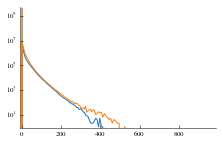

In [9]:
# plot
data = np.load("data/imerg2000-2005.npz")
bins = data["bins"]
hist_past = data["hist"]
data = np.load("data/imerg2016-2021.npz")
hist_present = data["hist"]

fig, ax = plt.subplots()
ax.semilogy(bins[:-1], hist_past)
ax.semilogy(bins[:-1], hist_present)
plt.savefig("imerg.png", bbox="tight")